In [1]:
import torch
import numpy as np
from skimage.measure import marching_cubes
from pytorch3d.structures import Meshes
from pytorch3d.io import save_obj
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader
)



In [2]:
from pysdf import SDF

# Load some mesh (don't necessarily need trimesh)
import trimesh
o = trimesh.load('data/cow_mesh/cow.obj')
f = SDF(o.vertices, o.faces); # (num_vertices, 3) and (num_faces, 3)

# # Compute some SDF values (negative outside);
# # takes a (num_points, 3) array, converts automatically
# origin_sdf = f([0, 0, 0])
# sdf_multi_point = f([[0, 0, 0],[1,1,1],[0.1,0.2,0.2]])

# # Contains check
# origin_contained = f.contains([0, 0, 0])

# # Misc: nearest neighbor
# origin_nn = f.nn([0, 0, 0])

# # Misc: uniform surface point sampling
# random_surface_points = f.sample_surface(10000)

# # Misc: surface area
# the_surface_area = f.surface_area

In [11]:

# mosaic_sdf = optimizer.model
resolution = 64
device = 'cpu'


# # Assuming 'mosaic_sdf' is your MosaicSDF instance and 'resolution' is the desired grid resolution
grid_points = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, resolution),
    torch.linspace(-1, 1, resolution),
    torch.linspace(-1, 1, resolution)
), dim=-1).reshape(-1, 3)#.to(device)

sdf_values = f(grid_points)
sdf_values *= -1
sdf_volume = sdf_values.reshape(resolution, resolution, resolution)

# # Get the SDF values at these points
# sdf_values = mosaic_sdf(grid_points).detach().cpu().numpy()
# sdf_volume = sdf_values.reshape(resolution, resolution, resolution)
# sdf_volume.shape

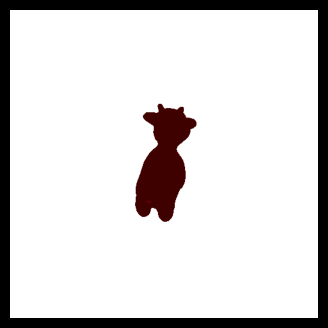

In [12]:

from pytorch3d.renderer.mesh.textures import Textures
from shape_sampler import ShapeSampler

# Run marching cubes to get vertices, faces, and normals
verts, faces, normals, values = marching_cubes(sdf_volume, level=0)
# faces = faces + 1  # skimage has 0-indexed faces, while PyTorch3D expects 1-indexed

# Convert to PyTorch tensors
verts = torch.tensor(verts.copy(), dtype=torch.float32)
verts = ShapeSampler.normalize_shape(verts)

faces = torch.tensor(faces.copy(), dtype=torch.int64)

total_verts = verts.shape[0]
verts_rgb = torch.ones((1, total_verts, 3), device=device)
verts_rgb *= torch.tensor([.5, 0, 0], device=device)
# verts_rgb *= torch.tensor(verts, device=device)
# Initialize the textures with the corrected verts_rgb
textures = Textures(verts_rgb=verts_rgb)

# Create a PyTorch3D mesh
mesh = Meshes(verts=[verts], faces=[faces], textures=textures)

# Initialize a renderer
R, T = look_at_view_transform(5, 45, 15)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)

# Render the mesh


with torch.no_grad():
    images = renderer(mesh.to(device))

    # vis.shape
    plt.figure(figsize=(4, 4))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")

# images


In [14]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "mesh": mesh
    }
})
fig.show()    